# Fine-Tuning Representation Models for Classfication

## Supervised Classification

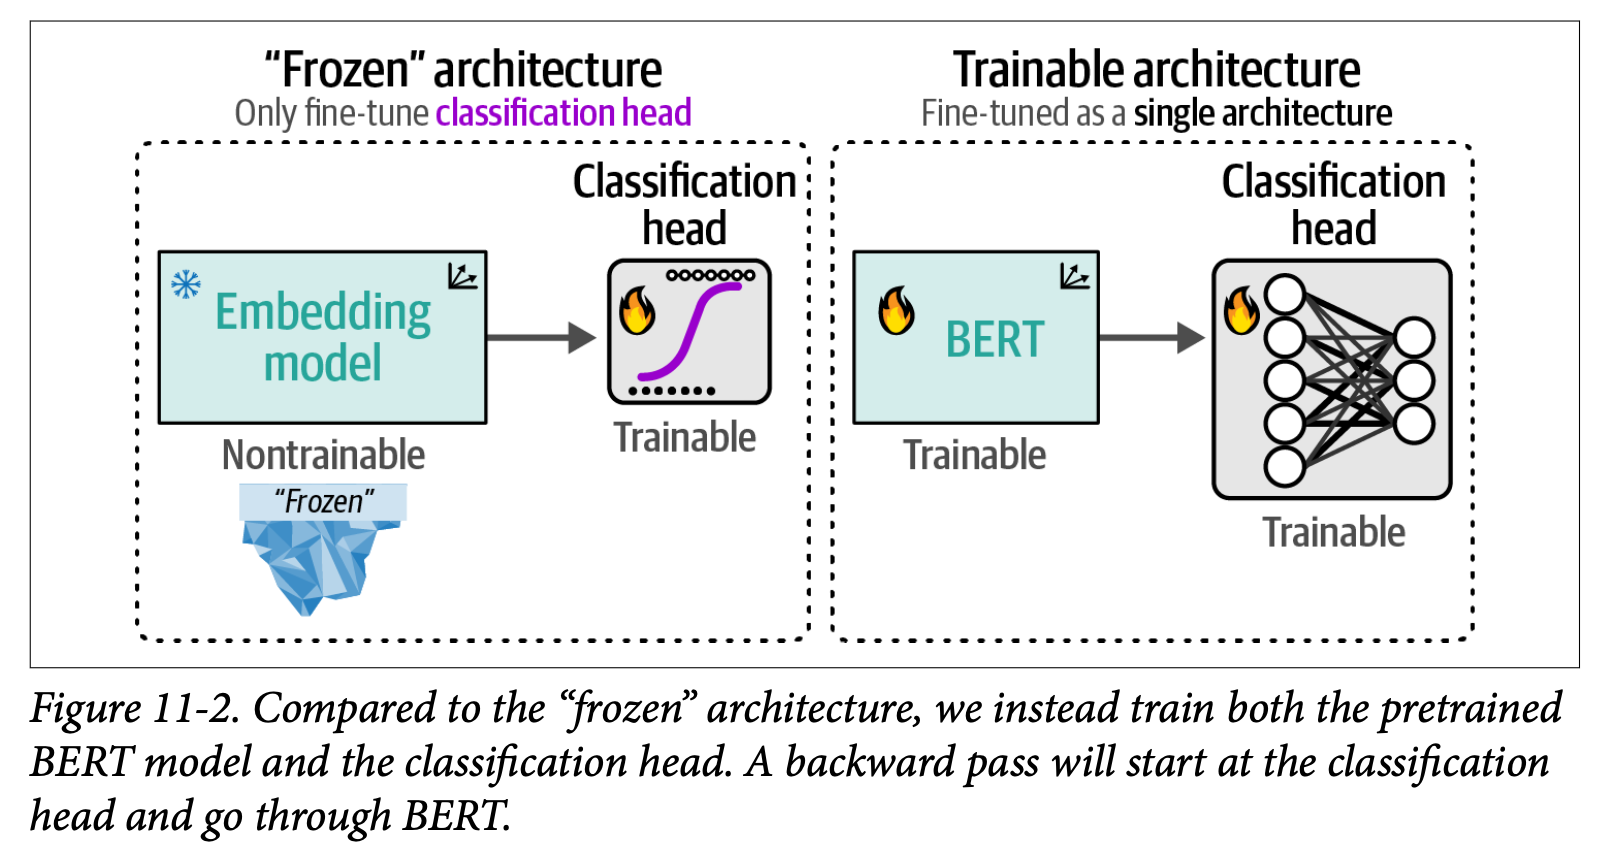


### FineTuning a Pretrained BERT model

We will use a pretrained BERT model and add a neural network as a classification head, both of which will be
fine-tuned for classification.

In practice, this means that the pretrained BERT model and the classification head are updated jointly. Instead of independent processes, they learn from one another and allow for more accurate representations.

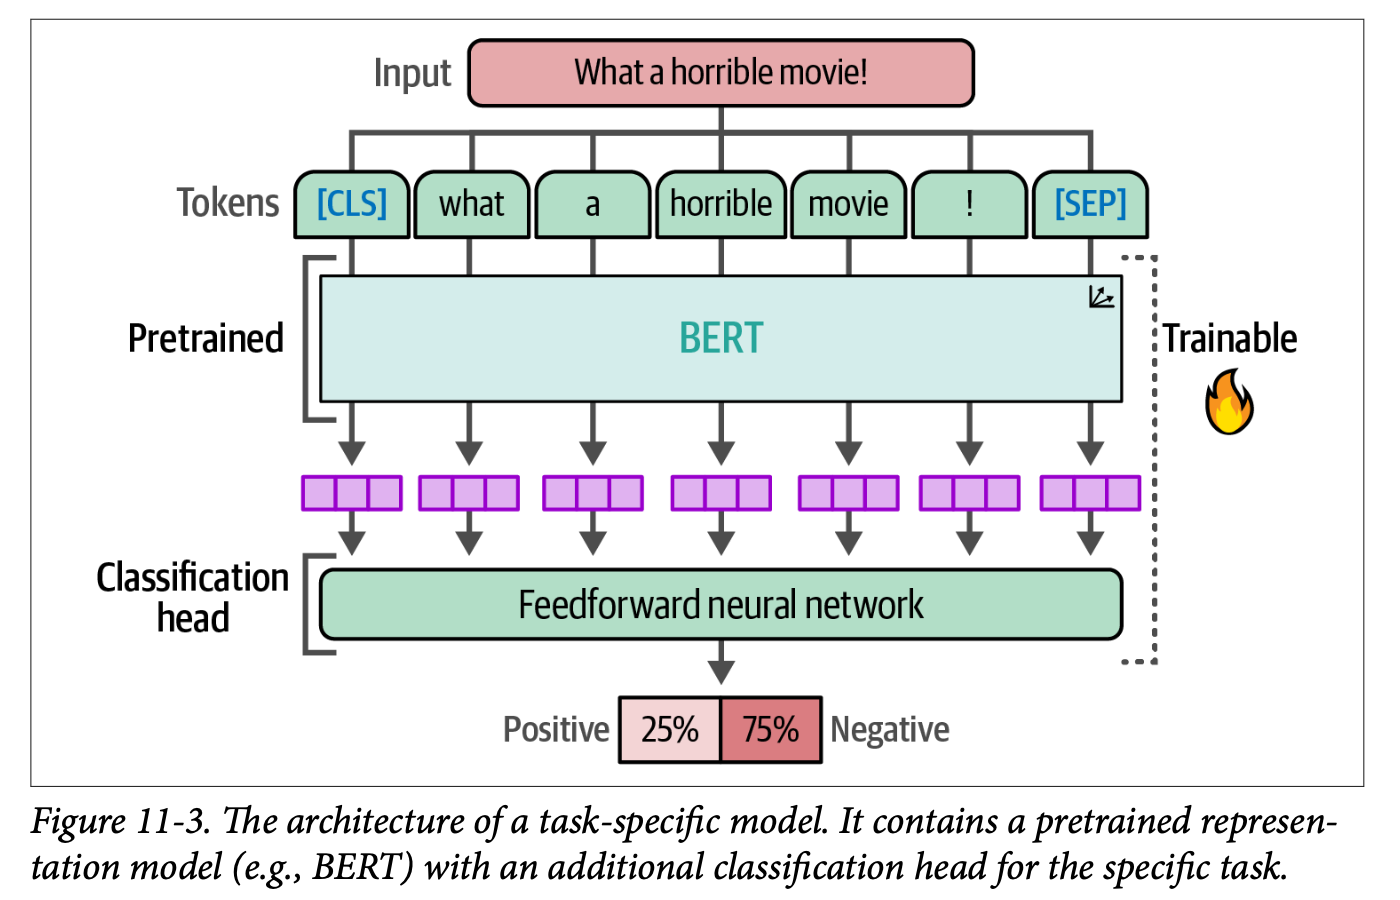


We will be using Rotten Tomatoes dataset which contains 5,331 positive and 5,331 negative movie reviews from Rotten Tomatoes.

In [2]:
from datasets import load_dataset

# Prepare data and splits
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

We define the number of labels that we want to predict beforehand. This is necessary to create the feedforward neural network that is applied on top of our pretrained model.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load model and tokenizer
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels = 2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)


In [ ]:
# Tokenizing our data

from transformers import DataCollatorWithPadding

# Pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)



In [ ]:
def preprocess_function(examples):
    """Tokenize input data"""
    return tokenizer(examples["text"], truncation = True)


In [ ]:
# Tokenize train and test data
tokenized_train = train_data.map(preprocess_function, batched = True)
tokenized_test = test_data.map(preprocess_function, batched = True)

A DataCollator is a class that helps us build batches of data but also allows us to apply data augmentation.

During this process of tokenization, we will add padding to the input text to create equally sized representations. We use DataCollatorWithPadding for that.

In [2]:
import numpy as np
import evaluate
from sklearn.metrics import f1_score


def compute_metrics(eval_pred):
    """Calculate F1 score"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Load Hugging Face evaluate metric
    load_f1 = evaluate.load("f1")

    # Compute F1 score using sklearn
    f1_value = f1_score(labels, predictions, average = "binary")

    return {"f1": float(f1_value)}

With compute_metrics we can define any number of metrics that we are interested in and that can be printed out or logged during training. This is especially helpful during training as it allows for detecting overfitting behavior.

In [ ]:
# Instantiating our Trainer

from transformers import TrainingArguments, Trainer

# Training arguments for parameter tunind
training_args = TrainingArguments(
    "model",
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 1,
    weight_decay = 0.01,
    save_strategy = "epoch"
)



In [ ]:
# Trainer which executes the training process
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_test,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
)


The TrainingArguments class defines hyperparameters we want to tune, such as the learning rate and how many epochs (rounds) we want to train. The Trainer is used to execute the training process.

In [ ]:
trainer.train()

In [ ]:
import transformers, datasets, evaluate
print(transformers.__version__, datasets.__version__, evaluate.__version__)


In [ ]:
# Evaluating our model
trainer.evaluate()

## Freezing Layers

We will freeze the main BERT model and allow only updates to pass through the classification head.


In [26]:
import numpy as np
import evaluate
from sklearn.metrics import f1_score


def compute_metrics(eval_pred):
    """Calculate F1 score"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Load Hugging Face evaluate metric
    load_f1 = evaluate.load("f1")

    # Compute F1 score using sklearn
    f1_value = f1_score(labels, predictions, average = "binary")

    return {"f1": float(f1_value)}

In [ ]:
# Let's reinitiliaze our model so that we can start from scratch

model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels = 2
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
# Print layer names
for name, param in model.named_parameters():
    print(name)

There are 12 (0–11) encoder blocks consisting of attention heads, dense networks, and layer normalization.

**1. Freezing Everything except the classfication head**

In [ ]:
for name, param in model.named_parameters():
    
    # Trainable classification head
    if name.startswith("classifier"):
        param.requires_grad = True
    
    # Freeze everything else
    else:
        param.requires_grad = False
        

In [ ]:
# We can check whether the model was correctly updated
for name, param in model.named_parameters():
    print(f"Parameter: {name} ------- {param.requires_grad}")

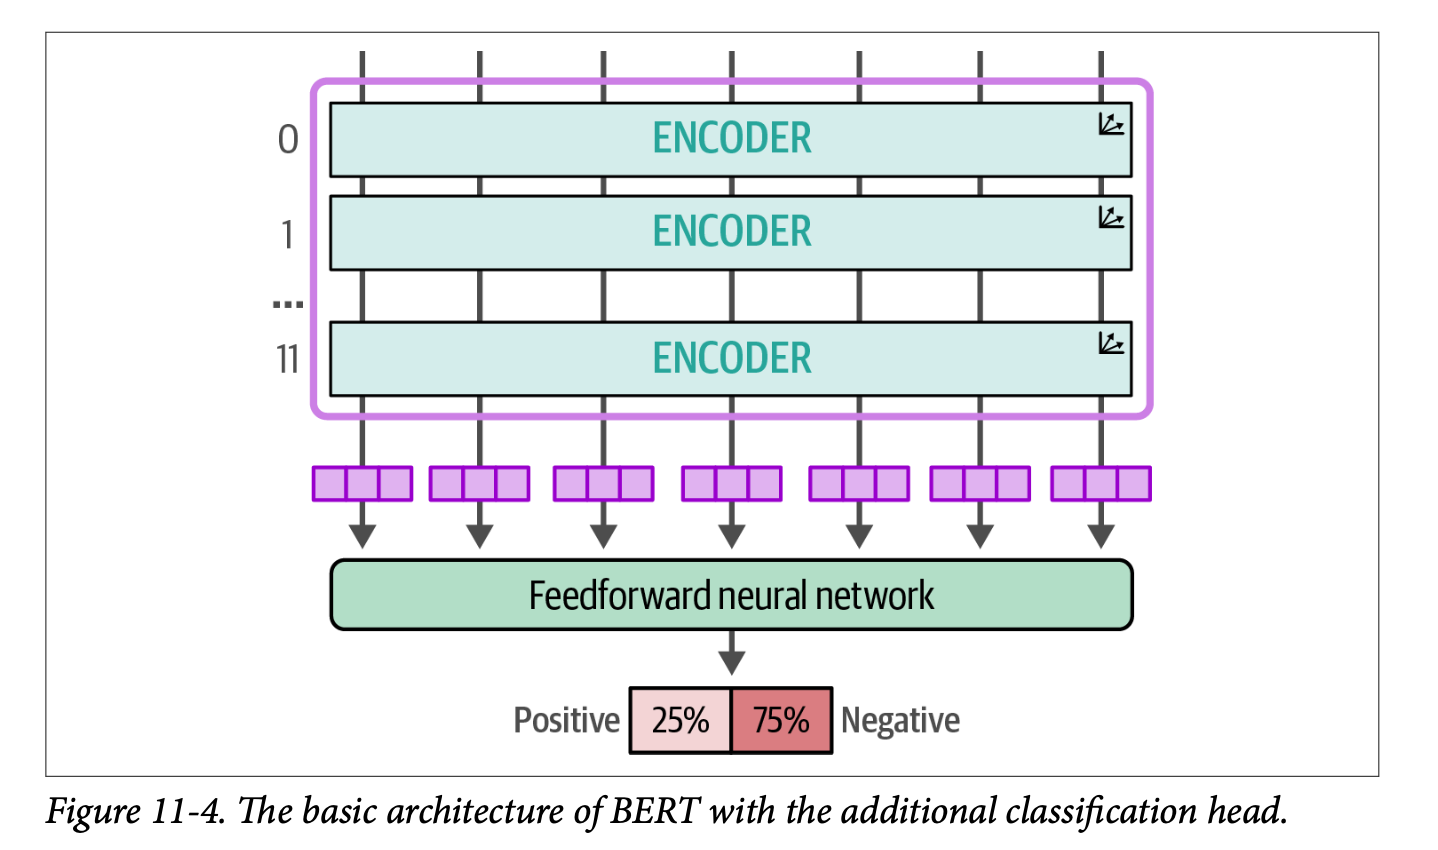

In [ ]:
from transformers import TrainingArguments, Trainer

# Trainer which executes the training process
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_test,
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
)
trainer.train()

In [ ]:
trainer.evaluate()

Now, We freeze the first 10 encoder blocks of our BERT model. Everything else is trainable and will be fine-tuned.

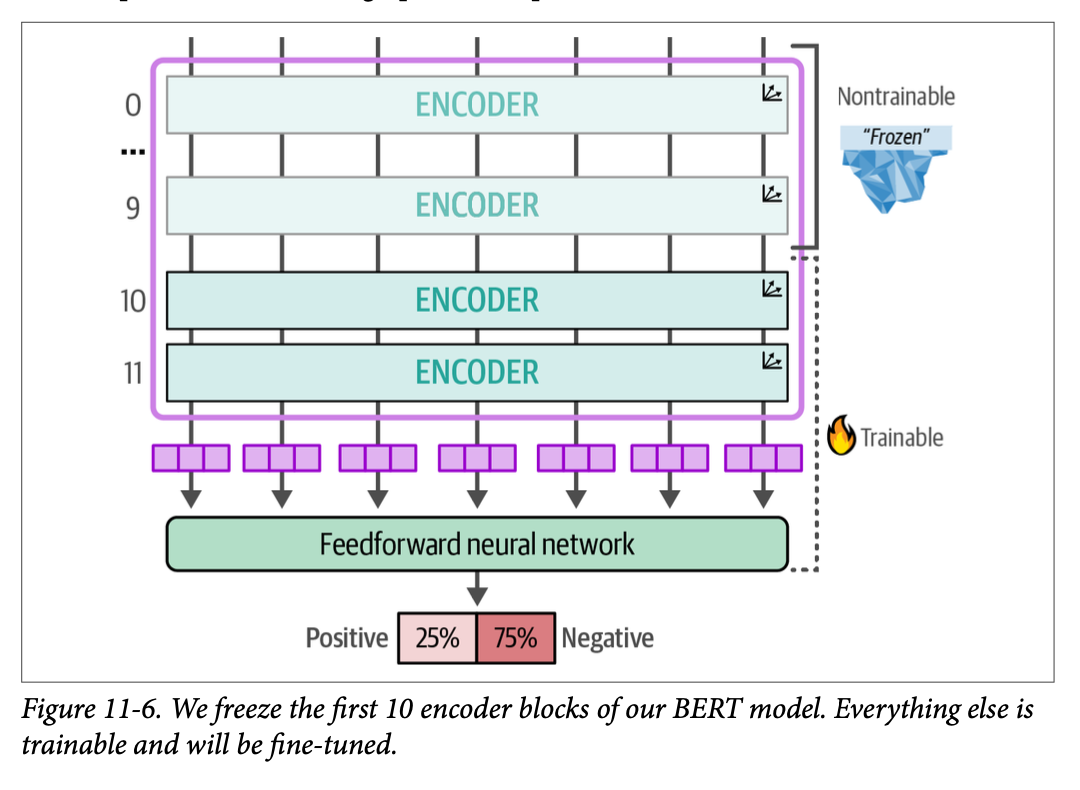

In [ ]:
# Load Model
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels = 2
)

tokenizer = AutoTokenizer.from_pretrained(model_id)


In [ ]:
# Encoder block 11 starts at index 165 and we freeze everything before that block
for index, (name, param) in enumerate(model.named_parameters()):
    if index < 165:
        param.requires_grad = False

In [ ]:
# We can check whether the model was correctly updated
for name, param in model.named_parameters():
    print(f"Parameter: {name} ------- {param.requires_grad}")

In [ ]:
# Trainer which executes the training process
trainer = Trainer(
    model=  model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_test,
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
)
trainer.train()

In [ ]:
trainer.evaluate()

### Freezing different Blocks of BERT


In [ ]:
scores = []
for index in range(12):
    # Reload the model
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

    # Freeze encode blocks 0-index
    for name, param in model.named_parameters():
        if "layer" in name:
            layer_nr = int(name.split("layer")[1].split(".")[1])
            if layer_nr <= index:
                param.requires_grad = False
            else:
                param.requires_grad = True

    # Train
    trainer = Trainer(
        model = model,
        args = training_args,
        train_dataset = tokenized_train,
        eval_dataset = tokenized_test,
        tokenizer = tokenizer,
        data_collator = data_collator,
        compute_metrics = compute_metrics,
    )

    # Evaluate
    score = trainer.evaluate()["eval_f1"]
    scores.append(score)


In [ ]:
scores

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create Figure
plt.figure(figsize = (8,4))

# Prepare Data
x = [f"0-{index}" for index in range(12)]

x[0] = "None"
x[-1] = "All"
y = [
    0.5973053892215568,
    0.05319148936170213,
    0.05319148936170213,
    0.05319148936170213,
    0.05319148936170213,
    0.05319148936170213,
    0.05319148936170213,
    0.05319148936170213,
    0.05319148936170213,
    0.05319148936170213,
    0.05319148936170213,
    0.05319148936170213
][::-1]

# Stylize figure
plt.grid(color = "#ECEFF1")
plt.axvline(x=4, color = "#EC407A", linestyle = "--")
plt.title("Effect of Frozen Encoder blocks on Training Performance")
plt.ylabel("F1-Score")
plt.xlabel("Trainable encoder blocks")

# Plot Data
plt.annotate(
    'Performance Stabilizing',
    xy = (4, y[4]),
    xytext = (4.5, y[4] - 0.4),
    arrowprops = dict(
        arrowstyle = "-|>",
        connectionstyle = "arc3",
        color = "#00ACC1"
    )
)
plt.savefig("multiple_frozen_blocks.png", dpi = 300, bbox_inches = "tight")


FACT : Training only the first five encode blocks(red vertical line) is enough to almost reach the performance of training all encoder blocks.

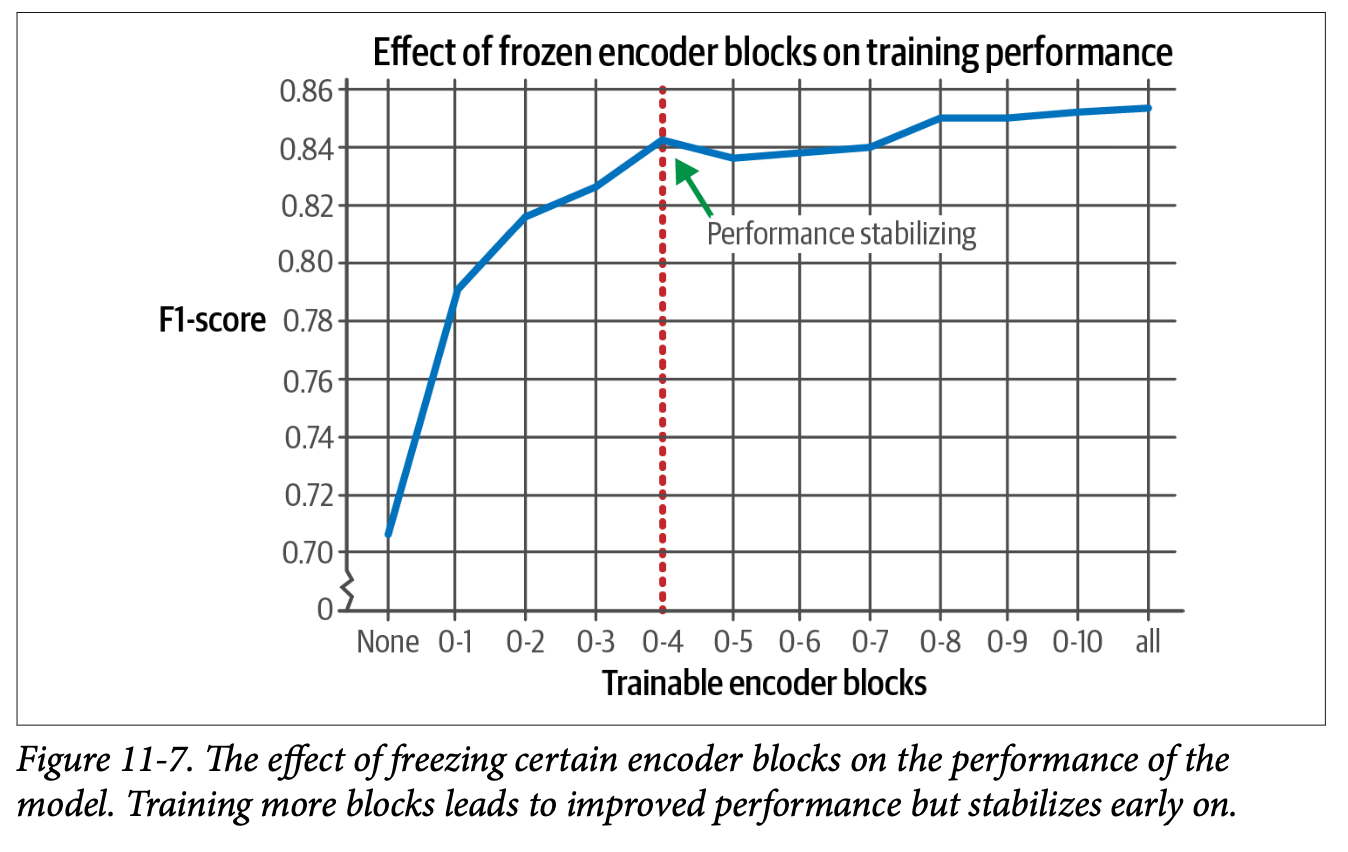

## Few Shot Classfication

Few-shot classification is a technique within supervised classification where you have a classifier learn target labels based on only a few labeled examples. 
- Great when you have a classification task but do not have many labeled data points readily available.

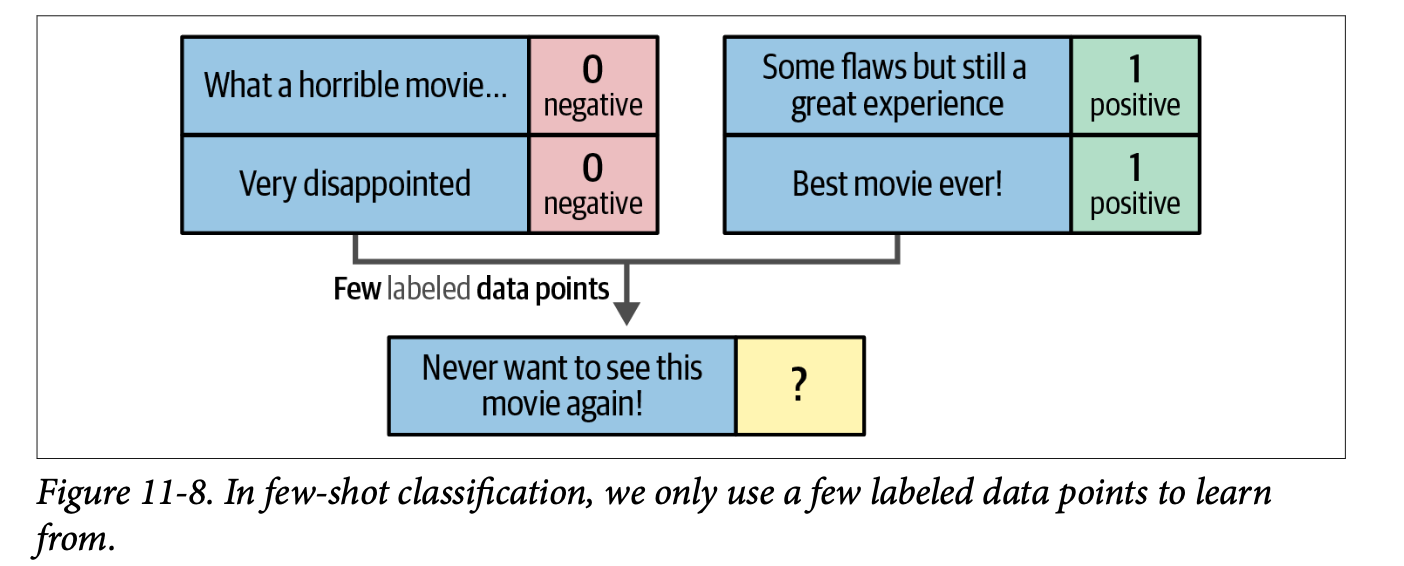



## SetFit : Efficient Fine Tuning with Few Training Examples

3 steps : 
1. Sampling Training Data - 
2. Fine Tuning embeddings
3. Training a classfier

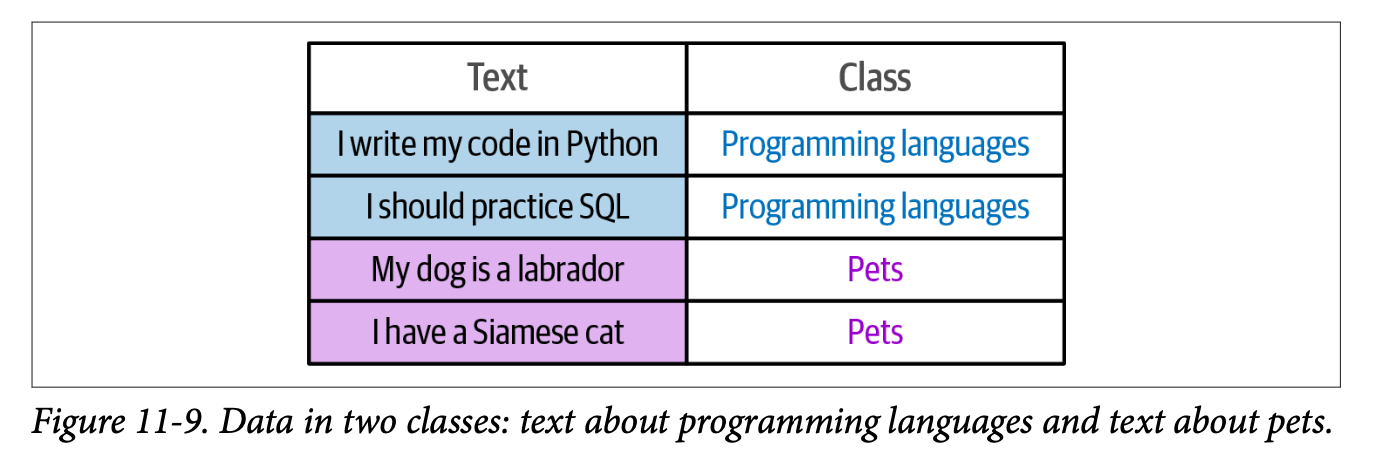

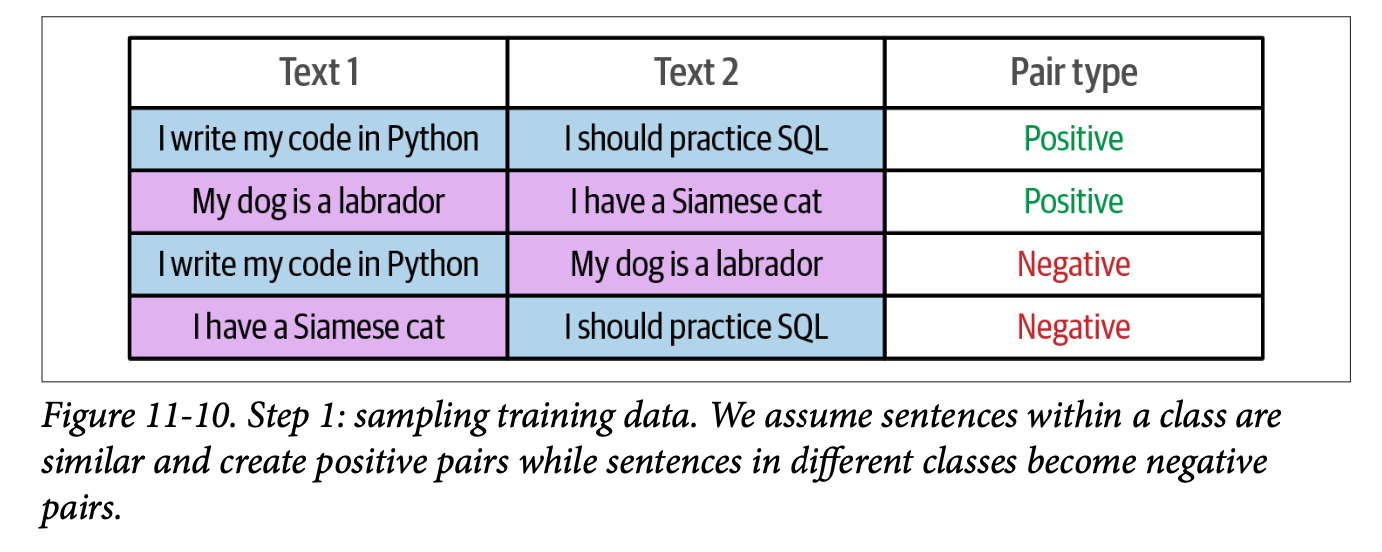

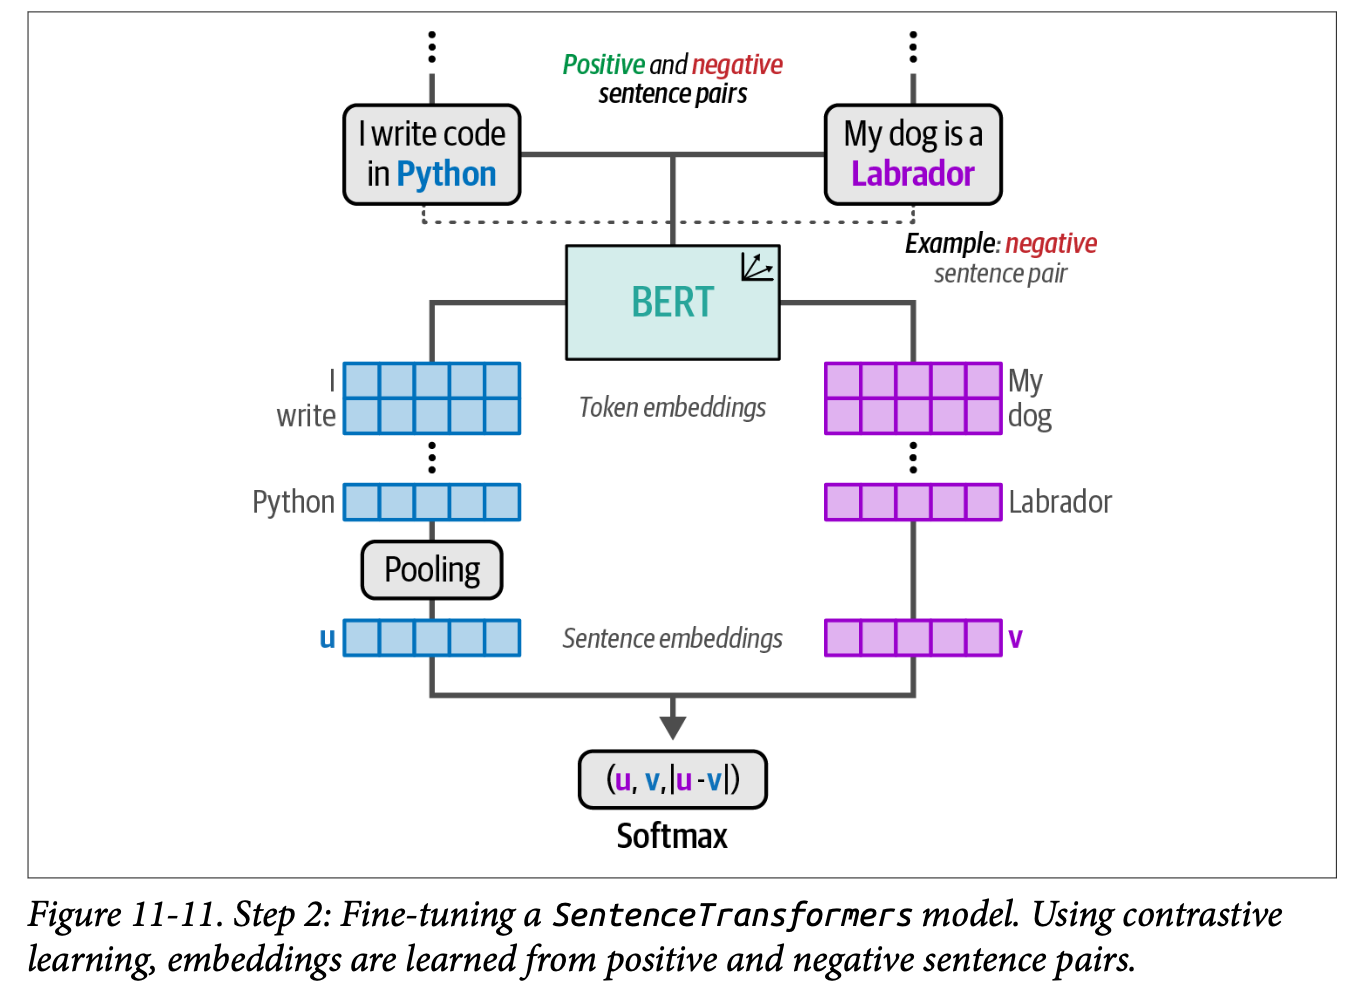

contrastive learning allows accurate sentence embeddings to be learned from pairs of similar (positive) and dissimilar (negative) sentences.

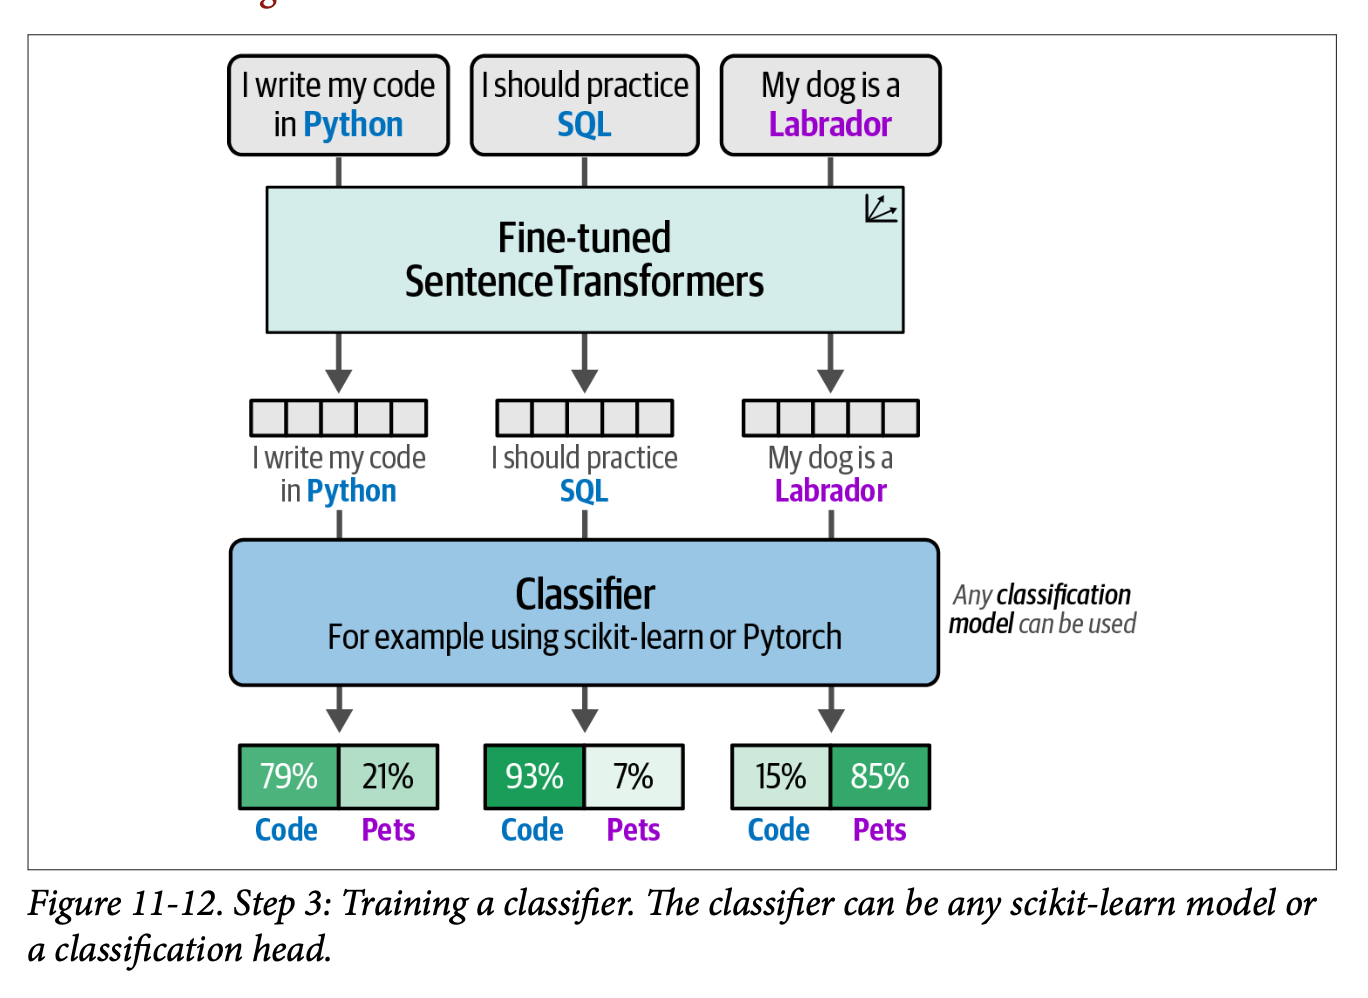

First, sentence pairs are generated based on in-class and out-class selection. Second, the sentence pairs are used to fine-tune a pretrained SentenceTransformer model. Third, the sentences are embedded with the fine-tuned model on which a classifier is trained to predict the classes.

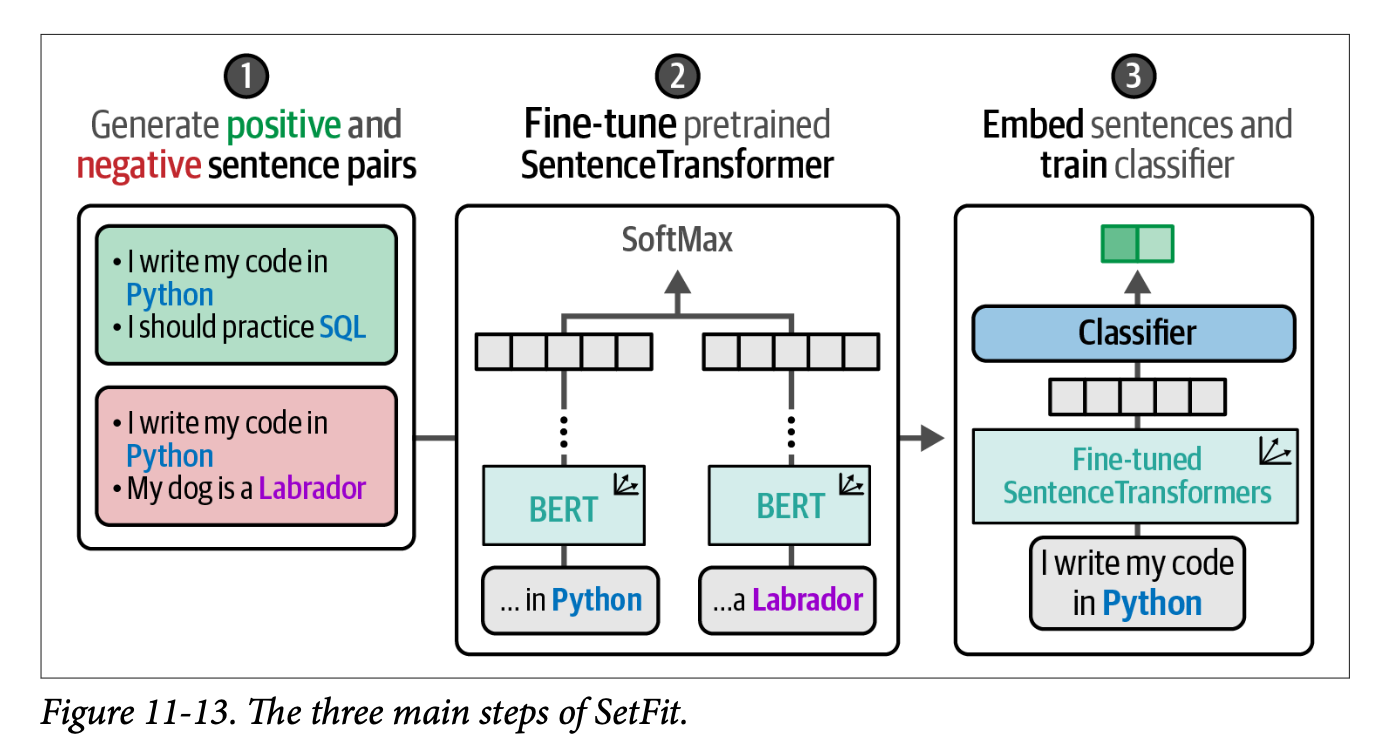

### Fine Tuning For Few-Shot Classfication

We previously trained on a dataset containing roughly 8,500 movie reviews. However, since this is a few-shot setting, we will only sample 16 examples per class. With two classes, we will only have 32 documents to train on compared to the 8,500 movie reviews we used before!

In [4]:
from setfit import sample_dataset

# we simulate a few-shot setting by sampling 16 examples per class
sampled_trained_data = sample_dataset(tomatoes["train"], num_samples = 16)

<a href= "https://www.sbert.net/docs/sentence_transformer/pretrained_models.html"> Overview of Pretrained Sentence Transformer models </a>

In [5]:
from setfit import SetFitModel

# Load a pre-trained SentenceTransformer model
model = SetFitModel.from_pretrained("strapp/all-mpnet-base-v2-solutions-1200")

/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


After loading in the pretrained SentenceTransformer model, we can start defining our SetFitTrainer. By default, a logistic regression model is chosen as the classifier to train.

In [6]:
from setfit import TrainingArguments as SetFitTrainingArguments
from setfit import Trainer as SetFitTrainer

In [7]:
# Define training arguments
args = SetFitTrainingArguments(
    num_epochs=  3,    # the number of epochs to use for contrastive learning
    num_iterations = 20     # the number of text_pairs to generate
)

In [8]:
args.eval_strategy = args.evaluation_strategy


In [ ]:
# Create a Trainer
trainer = SetFitTrainer(
    model = model,
    args = args,
    train_dataset = sampled_trained_data,
    eval_dataset = test_data,
    metric = "f1",
)

TypeError: Trainer.__init__() got an unexpected keyword argument 'compute_metrics'

In [ ]:
# Training Loop
trainer.train()

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3


  0%|          | 0/240 [00:00<?, ?it/s]

{'embedding_loss': 0.252, 'grad_norm': 7.089555263519287, 'learning_rate': 8.333333333333333e-07, 'epoch': 0.01}
{'embedding_loss': 0.0596, 'grad_norm': 0.012832717038691044, 'learning_rate': 1.7592592592592595e-05, 'epoch': 0.62}
{'embedding_loss': 0.0002, 'grad_norm': 0.005322373006492853, 'learning_rate': 1.2962962962962964e-05, 'epoch': 1.25}
{'embedding_loss': 0.0001, 'grad_norm': 0.011785688810050488, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.88}
{'embedding_loss': 0.0001, 'grad_norm': 0.0030140625312924385, 'learning_rate': 3.7037037037037037e-06, 'epoch': 2.5}
{'train_runtime': 59.1307, 'train_samples_per_second': 64.941, 'train_steps_per_second': 4.059, 'train_loss': 0.013317979218360658, 'epoch': 3.0}


Notice that the output mentions that 1,280 sentence pairs were generated for fine-tuning the SentenceTransformer model. As a default, 20 sentence pair combinations are generated for each sample in our data, which would be 20 * 32 = 680 samples. We will have to multiply this value by 2 for each positive and negative pair generated, 680 * 2 = 1,280 sentence pairs. Generating 1,280 sentence pairs is quite impressive considering we only had 32 labeled sentences to start with.

In [ ]:
# Evaluate the model on our test data
trainer.evaluate()

***** Running evaluation *****


AttributeError: 'float' object has no attribute 'size'

Not only can SetFit perform few-shot classification tasks, but it also has support for when you have no labels at all, also called zero-shot classification. SetFit generates synthetic examples from the label names to resemble the classification task and then trains a SetFit
model on them. For example, if the target labels are “happy” and “sad,” then synthetic data could be “The example is happy” and “This example is sad.”

When we do not specifically define a classification head, by default a logistic regression is used. If we would like to specify a classification head ourselves, we can do so by specifying the following model in SetFitTrainer.
```python
# Load a SetFit Model from hub
model = SetFitModel.from_pretrained(
    "sentence-transformers/all-mpnet-base-v2",
    use_differentiable_head = True,
    head_params = {"out_features": num_classes},
)

# Create a trainer
trainer = SetFitTrainer(
    model = model,
    ...
)
```

Here `num_classes` refers to the number of classes that we want to predict.

## Continued Pretraining with Masked Langauge Modeling

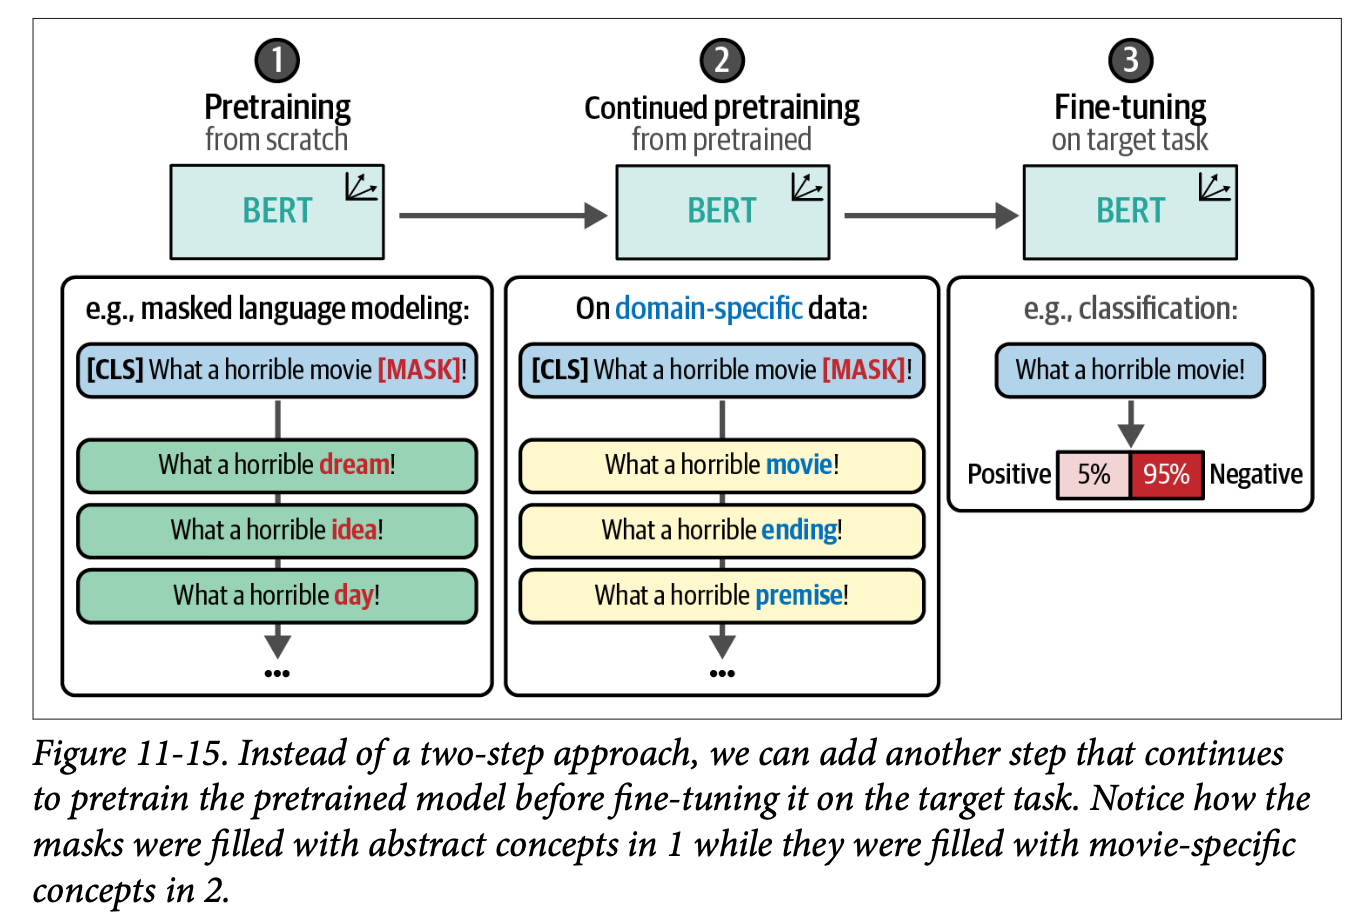

Instead of having to pretrain an entire model from scratch, we can simply continue pretraining before fine-tuning it for classification. This also helps the model to adapt to a certain domain or even the lingo of a specific organization.

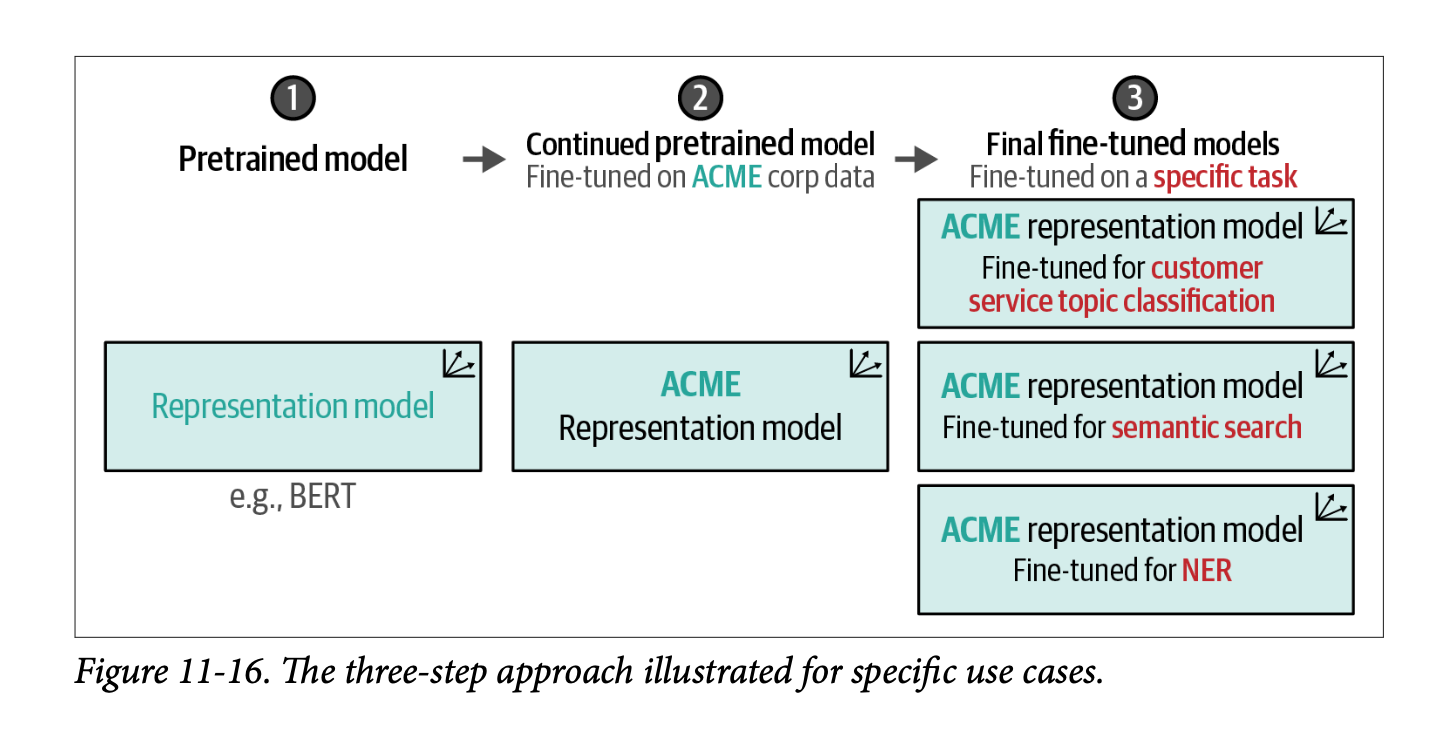



In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load the model for masked language modelling (MLM)
model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

We need to tokenize the raw sentences. We will also remove labels since this is not a supervised task.

In [3]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation = True)

# Tokenize the data
tokenized_train = train_data.map(preprocess_function, batched = True)
tokenized_train = tokenized_train.remove_columns("label")
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns("label")


Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [4]:
from transformers import DataCollatorForLanguageModeling

# Masking Tokens
data_collator = DataCollatorForLanguageModeling(
    tokenizer = tokenizer,
    mlm = True,
    mlm_probability = 0.15
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Now we will create the Trainer for running the MLM task and specify certain parameters.

In [5]:
from transformers import TrainingArguments, Trainer


# Training arguments for parameter tuning
training_args = TrainingArguments(
    "model",
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size= 16,
    num_train_epochs = 10,
    weight_decay = 0.01,
    save_strategy = "epoch",
    report_to = "none"
)

# Initialize the Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_test,
    tokenizer = tokenizer,
    data_collator = data_collator
)



Before we start our training loop we will first save our pretrained tokenizer. The tokenizer is not updated during training so there is no need to save it after training. We will, however, save our model after we continue pretraining.

In [6]:
# Save pre-trained tokenizer
tokenizer.save_pretrained("mlm")

# Train model
trainer.train()

# Save updated model
model.save_pretrained("mlm")

  0%|          | 0/5340 [00:00<?, ?it/s]

{'loss': 2.6031, 'grad_norm': 13.750250816345215, 'learning_rate': 1.812734082397004e-05, 'epoch': 0.94}
{'loss': 2.3771, 'grad_norm': 17.960054397583008, 'learning_rate': 1.6254681647940076e-05, 'epoch': 1.87}
{'loss': 2.2992, 'grad_norm': 21.801639556884766, 'learning_rate': 1.4382022471910113e-05, 'epoch': 2.81}
{'loss': 2.1891, 'grad_norm': 13.552038192749023, 'learning_rate': 1.250936329588015e-05, 'epoch': 3.75}
{'loss': 2.1398, 'grad_norm': 12.860613822937012, 'learning_rate': 1.0636704119850187e-05, 'epoch': 4.68}
{'loss': 2.095, 'grad_norm': 22.88814353942871, 'learning_rate': 8.764044943820226e-06, 'epoch': 5.62}
{'loss': 2.0588, 'grad_norm': 15.172350883483887, 'learning_rate': 6.891385767790263e-06, 'epoch': 6.55}
{'loss': 1.9887, 'grad_norm': 13.7988920211792, 'learning_rate': 5.0187265917603005e-06, 'epoch': 7.49}
{'loss': 1.9789, 'grad_norm': 19.10194206237793, 'learning_rate': 3.146067415730337e-06, 'epoch': 8.43}
{'loss': 1.967, 'grad_norm': 15.412796020507812, 'learni

In [11]:
from transformers import pipeline

# Load and create predictions
mask_filler = pipeline("fill-mask", model = "bert-base-cased")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


>>> What a horrible idea!
>>> What a horrible dream!
>>> What a horrible thing!
>>> What a horrible day!
>>> What a horrible thought!


In [12]:
# Let's see the updated model

# Load and create predictions
mask_filler = pipeline("fill-mask", model = "mlm")
preds = mask_filler("What a horrible [MASK]!")


# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


>>> What a horrible movie!
>>> What a horrible film!
>>> What a horrible mess!
>>> What a horrible story!
>>> What a horrible comedy!


## Named-Entity Recognition

fine-tuning a pretrained BERT model specifically for NER (named-entity recognition). Instead of classifying entire documents, this procedure allows for the classification of individual tokens and/or words, including people and locations. This is especially helpful for de-identification and anonymization tasks when there is sensitive data.

### Preparing Data for Named-Entity Recognition

In [13]:
# The CoNLL-2003 dataset for NER
dataset = load_dataset("conll2003", trust_remote_code = True)

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [14]:
example = dataset["train"][848]
example

{'id': '848',
 'tokens': ['Dean',
  'Palmer',
  'hit',
  'his',
  '30th',
  'homer',
  'for',
  'the',
  'Rangers',
  '.'],
 'pos_tags': [22, 22, 38, 29, 16, 21, 15, 12, 23, 7],
 'chunk_tags': [11, 12, 21, 11, 12, 12, 13, 11, 12, 0],
 'ner_tags': [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]}

In [15]:
label2id = {
    "0": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-MISC": 7,
    "I-MISC": 8
}
id2label = {index: label for label, index in label2id.items()}
label2id

{'0': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [16]:
from transformers import AutoModelForTokenClassification

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Load Model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels = len(id2label),
    id2label = id2label,
    label2id = label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Let's explore how the tokenizer would process our example

# Split the individual tokens into sub-tokens
token_ids = tokenizer(example["tokens"], is_split_into_words = True)["input_ids"]

sub_tokens = tokenizer.convert_ids_to_tokens(token_ids)
sub_tokens

['[CLS]',
 'Dean',
 'Palmer',
 'hit',
 'his',
 '30th',
 'home',
 '##r',
 'for',
 'the',
 'Rangers',
 '.',
 '[SEP]']

In [18]:
def align_labels(examples):
    token_ids = tokenizer(
        examples["tokens"],
        truncation = True,
        is_split_into_words = True
    )
    labels = examples["ner_tags"]
    updated_labels = []

    for index, label in enumerate(labels):

        # Map tokens to their respective word
        word_ids = token_ids.word_ids(batch_index = index)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:

            # The start of a new word
            if word_ids != previous_word_idx:

                previous_word_idx = word_idx
                updated_label = -100 if word_idx is None else label[word_idx]
                label_ids.append(updated_label)

            # Special token is -100
            elif word_idx is None:
                label_ids.append(-100)

            # If the label is B-XXX we change it to I-XXX
            else:
                updated_label = label[word_idx]
                if updated_label % 2 == 1:
                    updated_label += 1
                label_ids.append(label_ids)

        updated_labels.append(label_ids)

    token_ids["labels"] = updated_labels
    return token_ids
    
tokenized = dataset.map(align_labels, batched = True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [20]:
# Difference between original and updated labels
print(f"Original: {example['ner_tags']}")
print(f"Updated: {tokenized['train'][848]['labels']}")

Original: [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]
Updated: [-100, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, -100]


We will make use of the evaluate package by Hugging Face to create a `compute_metrics` function that allows us to evaluate performance on a token level.

In [30]:
import evaluate

# Load sequential evaluation
seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    # Create predictions
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2)

    true_predictions = []
    true_labels = []

    # Document-level iteration
    for prediction, label in zip(predictions, labels):

      # token-level iteration
      for token_prediction, token_label in zip(prediction, label):

        # We ignore special tokens
        if token_label != -100:
          true_predictions.append([id2label[int(token_prediction)]])
          true_labels.append([id2label[int(token_label)]])

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {"f1": results["overall_f1"]}

### Fine-Tuning for Named-Entity Recognition

In [22]:
from transformers import DataCollatorForTokenClassification

# Token Classification Data Collator
data_collator = DataCollatorForTokenClassification(tokenizer = tokenizer)

In [32]:

# Training arguments for parameter tuning
training_args = TrainingArguments(
    "model",
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 1,
    weight_decay = 0.01,
    save_strategy = "epoch",
    report_to = "none"
)

# Initializa the trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized["train"],
    eval_dataset = tokenized["test"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

trainer.train()

  0%|          | 0/878 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [33]:

trainer.evaluate()

  0%|          | 0/216 [00:00<?, ?it/s]

/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.16049689054489136, 'eval_f1': 0.8964391976197332, 'eval_runtime': 8.7943, 'eval_samples_per_second': 392.641, 'eval_steps_per_second': 24.561, 'epoch': 0.06}


{'eval_loss': 0.16049689054489136,
 'eval_f1': 0.8964391976197332,
 'eval_runtime': 8.7943,
 'eval_samples_per_second': 392.641,
 'eval_steps_per_second': 24.561,
 'epoch': 0.06264236902050115}

Lastly, let’s save the model and use it in a pipeline for inference. This allows us to check certain data so we can manually inspect what happens during inference and if we are satisfied with the output.

In [37]:
from transformers import pipeline

# Save our fine tuned model
trainer.save_model("ner_model")

# Run inference on the fine-tuned model
token_classifier = pipeline(
    "ner",
    model = "ner_model"
)

token_classifier("My name is Maarten")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity': '0',
  'score': 0.9965004,
  'index': 1,
  'word': 'My',
  'start': 0,
  'end': 2},
 {'entity': '0',
  'score': 0.9975924,
  'index': 2,
  'word': 'name',
  'start': 3,
  'end': 7},
 {'entity': '0',
  'score': 0.99832517,
  'index': 3,
  'word': 'is',
  'start': 8,
  'end': 10},
 {'entity': 'B-PER',
  'score': 0.9414498,
  'index': 4,
  'word': 'Ma',
  'start': 11,
  'end': 13},
 {'entity': 'B-PER',
  'score': 0.94688064,
  'index': 5,
  'word': '##arte',
  'start': 13,
  'end': 17},
 {'entity': 'B-PER',
  'score': 0.975256,
  'index': 6,
  'word': '##n',
  'start': 17,
  'end': 18}]